In [1]:
from sunpy.net import Fido, attrs as a
from pprint import pprint
import pandas as pd
import json

import numpy as np
from sunpy.time import parse_time
from sunpy.timeseries import TimeSeries
from astropy import units as u
from astropy.time import Time
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

import astropy.io.fits

import src.instruments.alg_tools as at


c:\Users\James\Documents\code\solar_flare_finder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Flare List

In [8]:
start_date = '2013-11-09 05:00'
end_date = '2013-11-09 07:00'

start_date = '2013-11-08'
end_date = '2013-11-09'

# start_date = '2024-10-05'
# end_date = '2024-10-18'
start_date = '2014-05-01'
end_date = '2014-06-01'

hek_result = Fido.search(
    a.Time(start_date, end_date),
    a.hek.EventType('FL'),
    # a.hek.FL.GOESCls > 'C2.5'
)


In [15]:
flare_list = hek_result[0][
    'event_starttime',
    'event_peaktime',
    'event_endtime',
    'fl_goescls',
    'hpc_x',
    'hpc_y',
    'obs_instrument'
]

flare_list_df = flare_list.to_pandas()


In [ ]:
# flare_list_df.groupby('event_peaktime').filter(lambda x: len(x) > 1)
flare_list_df.groupby('obs_instrument')['obs_instrument'].count()

In [ ]:
flare_list_df = flare_list_df[flare_list_df['obs_instrument'] != "GOES"]#.drop('obs_instrument', axis=1)
flare_list_df


In [ ]:
print(f"With GOES Class: {flare_list_df['fl_goescls'].apply(lambda x: x!='').sum()}") # Number of rows with a GOES class
print(f"Without GOES Class: {flare_list_df['fl_goescls'].apply(lambda x: x=='').sum()}") # Number of rows without GOES class
flare_list_df = flare_list_df[flare_list_df['fl_goescls'] != ''].reset_index(drop=True)

In [ ]:
pd.set_option('display.max_rows', 10)
df = flare_list_df[['event_peaktime', 'obs_instrument']].groupby('event_peaktime').count()
df[df['obs_instrument'] > 1]
# flare_list_df[flare_list_df['event_peaktime'] == '2024-10-14 03:24:00']


In [ ]:
flare_list_df

# RHESSI Observation Algorithm

In [ ]:
flare_start, flare_peak, flare_end = '2013-11-09 06:22', '2013-11-09 06:38', '2013-11-09 06:47'
debug = False

# Convert input times to Time objects
flare_start = parse_time(flare_start)
flare_peak = parse_time(flare_peak)
flare_end = parse_time(flare_end)

# Handling case where flare_start equals flare_peak
if flare_start == flare_peak:
    flare_start -= 60 * u.s  # Subtract 1 min from flare_start

# Handling case where flare_peak equals flare_end
if flare_peak == flare_end:
    flare_end += 60 * u.s  # Add 1 min to flare_end

# Handling malformed time sequence
if not (flare_start < flare_peak < flare_end):
    out = {
        "rsi_observed": -1,
        "rsi_flare_triggered": -1,
        "rsi_frac_obs": -1.0,
        "rsi_frac_obs_rise": -1.0,
        "rsi_frac_obs_fall": -1.0
    }

# Create time range
time_range = [flare_start.iso, flare_end.iso]
that_day = [flare_start.strftime('%Y-%m-%d'), flare_end.strftime('%Y-%m-%d') + " 23:59:59"]

# Query RHESSI data for the given time range
query = Fido.search(a.Time(time_range[0], time_range[1]), a.Instrument.rhessi)
if not query:
    out = {
        "rsi_observed": 0,
        "rsi_flare_triggered": 0,
        "rsi_frac_obs": 0.0,
        "rsi_frac_obs_rise": 0.0,
        "rsi_frac_obs_fall": 0.0
    }

result = Fido.fetch(query)

countrate_data = TimeSeries(result[0]).to_dataframe()

# Open the RHESSI FITS file using astropy.io.fits
with astropy.io.fits.open(result[0]) as hdulist:
    flag_info = hdulist['HSI_OBSSUMMFLAGINFO'].data
    flag_names = np.array([s.strip().lower() for s in flag_info['FLAG_IDS'][0]])
    flag_data = hdulist['HSI_OBSSUMMFLAGDATA'].data['flags']
    
    flag_df = pd.DataFrame(flag_data, columns=flag_names)
    flag_df['datetime'] = countrate_data.index
    flag_columns = flag_df.columns.difference(['datetime'])  # Get flag columns except 'datetime'
    flag_df[flag_columns] = flag_df[flag_columns].astype(bool)
    flag_df['observable'] = ~(flag_df['saa_flag'] | flag_df['eclipse_flag'])

countrate_data = countrate_data[(countrate_data.index > time_range[0]) & (countrate_data.index < time_range[1])]
flags_during_flare = flag_df[(flag_df['datetime'] > time_range[0]) & (flag_df['datetime'] < time_range[1])].reset_index()


In [ ]:
flags_during_flare[
    [
        'datetime',
        'saa_flag',
        'eclipse_flag',
        'observable'
    ]
]

In [ ]:
# Check if RHESSI observed during flare
rsi_observed = np.any(countrate_data != 0)

# Plots for debugging
if debug:
    TimeSeries(result).plot()

if rsi_observed:
    # Assume flags are represented in the data (e.g. "FLARE_FLAG", "ECLIPSE_FLAG")
    flare_flag = np.array(flags_during_flare['flare_flag'])
    observable_flag = np.array(flags_during_flare['observable'])

    # Plots for debugging flags
    if debug:
        plt.plot(observable_flag)
        plt.ylim([-0.1, 1.1])
        plt.show()

        plt.plot(countrate_data.index, countrate_data['3 - 6 keV'], label=['3 - 6 keV'])
        # plt.plot(countrate_data.index, countrate_data, label=countrate_data.columns)
        plt.legend()
        plt.show()

    # Calculate statistics
    total_elements = len(observable_flag)
    elements_to_flare_peak = (flags_during_flare['datetime'] - pd.to_datetime(flare_peak.iso)).abs().idxmin()

    if True: #verbose:
        print(f"Flare Start: {flare_start}")
        print(f"Flare Peak: {flare_peak}")
        print(f"Flare End: {flare_end}")
        print(f"Elements to flare peak: {elements_to_flare_peak}")
        print(f"Total Number of Elements: {total_elements}")

    rsi_flare_triggered = np.any(flare_flag != 0)
    rsi_frac_obs = np.sum(observable_flag) / total_elements
    rsi_frac_obs_rise = np.sum(observable_flag[:elements_to_flare_peak]) / elements_to_flare_peak
    rsi_frac_obs_fall = np.sum(observable_flag[elements_to_flare_peak:]) / (total_elements - elements_to_flare_peak)

else:
    rsi_flare_triggered = 0
    rsi_frac_obs = 0.0
    rsi_frac_obs_rise = 0.0
    rsi_frac_obs_fall = 0.0

out = {
    "rsi_observed": int(rsi_observed),
    "rsi_flare_triggered": int(rsi_flare_triggered),
    "rsi_frac_obs": rsi_frac_obs,
    "rsi_frac_obs_rise": rsi_frac_obs_rise,
    "rsi_frac_obs_fall": rsi_frac_obs_fall
}

print()
pprint(out)


# Fermi Observation Algorithm

In [ ]:
# import pandas as pd
# import numpy as np
# from matplotlib import pyplot as plt
# from sunpy.net import Fido, attrs as a
# from sunpy.timeseries import TimeSeries
# from sunpy.time import parse_time
# from astropy import units as u
# import astropy.io.fits

# flare_start, flare_peak, flare_end = '2013-11-09 06:22', '2013-11-09 06:38', '2013-11-09 06:47'
# debug = False
# verbose = True

# # Convert input times to Time objects
# flare_start = parse_time(flare_start)
# flare_peak = parse_time(flare_peak)
# flare_end = parse_time(flare_end)

# # Handling case where flare_start equals flare_peak
# if flare_start == flare_peak:
#     flare_start -= 60 * u.s  # Subtract 1 min from flare_start

# # Handling case where flare_peak equals flare_end
# if flare_peak == flare_end:
#     flare_end += 60 * u.s  # Add 1 min to flare_end

# # Handling malformed time sequence
# if not (flare_start < flare_peak < flare_end):
#     out = {
#         "fermi_observed": -1,
#         "fermi_flare_triggered": -1,
#         "fermi_frac_obs": -1.0,
#         "fermi_frac_obs_rise": -1.0,
#         "fermi_frac_obs_fall": -1.0
#     }
#     print(out)

# # Create time range
# time_range = [flare_start.iso, flare_end.iso]

# # Query Fermi GBM data for the given time range
# query = Fido.search(a.Time(time_range[0], time_range[1]), a.Instrument.gbm)
# if not query:
#     out = {
#         "fermi_observed": 0,
#         "fermi_flare_triggered": 0,
#         "fermi_frac_obs": 0.0,
#         "fermi_frac_obs_rise": 0.0,
#         "fermi_frac_obs_fall": 0.0
#     }
#     print(out)

# result = Fido.fetch(query)

# countrate_data = TimeSeries(result[0]).to_dataframe()

# # Open the Fermi FITS file using astropy.io.fits
# with astropy.io.fits.open(result[0]) as hdulist:
#     flag_info = hdulist['GBM_FLAG_INFO'].data
#     flag_names = np.array([s.strip().lower() for s in flag_info['FLAG_IDS'][0]])
#     flag_data = hdulist['GBM_FLAG_DATA'].data['flags']

#     flag_df = pd.DataFrame(flag_data, columns=flag_names)
#     flag_df['datetime'] = countrate_data.index
#     flag_columns = flag_df.columns.difference(['datetime'])
#     flag_df[flag_columns] = flag_df[flag_columns].astype(bool)
#     flag_df['observable'] = ~(flag_df['eclipse_flag'] | flag_df['saa_flag'])

# # Filter data for the flare time range
# countrate_data = countrate_data[(countrate_data.index > time_range[0]) & (countrate_data.index < time_range[1])]
# flags_during_flare = flag_df[(flag_df['datetime'] > time_range[0]) & (flag_df['datetime'] < time_range[1])].reset_index()

# # Check if Fermi observed during flare
# fermi_observed = np.any(countrate_data != 0)

# if debug:
#     TimeSeries(result).plot()

# if fermi_observed:
#     flare_flag = np.array(flags_during_flare['flare_flag'])
#     observable_flag = np.array(flags_during_flare['observable'])

#     if debug:
#         plt.plot(observable_flag)
#         plt.ylim([-0.1, 1.1])
#         plt.show()

#         plt.plot(countrate_data.index, countrate_data['12-25 keV'], label=['12-25 keV'])
#         plt.legend()
#         plt.show()

#     total_elements = len(observable_flag)
#     elements_to_flare_peak = (flags_during_flare['datetime'] - pd.to_datetime(flare_peak.iso)).abs().idxmin()

#     if verbose:
#         print(f"Flare Start: {flare_start}")
#         print(f"Flare Peak: {flare_peak}")
#         print(f"Flare End: {flare_end}")
#         print(f"Elements to flare peak: {elements_to_flare_peak}")
#         print(f"Total Number of Elements: {total_elements}")

#     fermi_flare_triggered = np.any(flare_flag != 0)
#     fermi_frac_obs = np.sum(observable_flag) / total_elements
#     fermi_frac_obs_rise = np.sum(observable_flag[:elements_to_flare_peak]) / elements_to_flare_peak
#     fermi_frac_obs_fall = np.sum(observable_flag[elements_to_flare_peak:]) / (total_elements - elements_to_flare_peak)

# else:
#     fermi_flare_triggered = 0
#     fermi_frac_obs = 0.0
#     fermi_frac_obs_rise = 0.0
#     fermi_frac_obs_fall = 0.0

# out = {
#     "fermi_observed": int(fermi_observed),
#     "fermi_frac_obs": int(fermi_frac_obs),
#     "fermi_frac_obs_rise": int(fermi_frac_obs_rise),
#     "fermi_frac_obs_fall": int(fermi_frac_obs_fall)
# }


In [30]:
# flare_start, flare_peak, flare_end = '2013-11-09 06:22', '2013-11-09 06:38', '2013-11-09 06:47'
# flare_start, flare_peak, flare_end = '2010-04-17 04:30', '2010-04-17 05:57', '2010-04-17 08:24'
flare_start, flare_peak, flare_end = '2012-01-27 17:37', '2012-01-27 18:37', '2012-01-27 18:56'

debug = False
verbose = True

# Convert input times to Time objects
flare_start = parse_time(flare_start)
flare_peak = parse_time(flare_peak)
flare_end = parse_time(flare_end)

# Query for Fermi GBM data using Fido
query = Fido.search(
    a.Time(flare_start, flare_end),
    a.Instrument.gbm,
    a.Detector('n0'),
    a.Resolution('cspec')
)

# Print query results
print(query)

# Download the files
result = Fido.fetch(query)

# Print the downloaded file paths
print(result)


Results from 1 Provider:

1 Results from the GBMClient:
Source: https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/daily

       Start Time               End Time        ... Resolution Detector
----------------------- ----------------------- ... ---------- --------
2012-01-27 00:00:00.000 2012-01-27 23:59:59.999 ...      cspec       n0




Files Downloaded: 100%|██████████| 1/1 [00:05<00:00,  5.08s/file]

['C:\\Users\\James\\sunpy\\data\\glg_cspec_n0_120127_v00.pha']


c:\Users\James\Documents\code\solar_flare_finder\.venv\Lib\site-packages\sunpy\timeseries\sources\fermi_gbm.py:227: RuntimeWarning: invalid value encountered in divide
  summary_counts.append(summed_counts/energy_width/count_data["exposure"])


<sunpy.timeseries.sources.fermi_gbm.GBMSummaryTimeSeries object at 0x00000222DD1AC8C0>
SunPy TimeSeries
----------------
Observatory:			GLAST
Instrument:			<a href=https://gammaray.nsstc.nasa.gov/gbm/# target="_blank">GBM</a>
Channel(s):			4-15 keV<br>15-25 keV<br>25-50 keV<br>50-100 keV<br>100-300 keV<br>300-800 keV<br>800-2000 keV
Start Date:			2012-01-26 23:59:55
End Date:			2012-01-27 23:59:57
Center Date:			2012-01-27 11:59:56
Resolution:			4.635 s
Samples per Channel:		18642
Data Range(s):		4-15 keV       1.54E+04<br>15-25 keV      3.20E+03<br>25-50 keV      3.14E+02<br>50-100 keV     4.64E+01<br>100-300 keV    3.77E+00<br>300-800 keV    3.55E-01<br>800-2000 keV   1.49E-01
Units:			ct / (keV s)
                                4-15 keV  15-25 keV  25-50 keV  50-100 keV  \
2012-01-26 23:59:55.244939983  11.496720  18.241268   8.201956    3.132635   
2012-01-26 23:59:59.340939999  11.683109  18.217994   8.123519    3.027631   
2012-01-27 00:00:03.437007964  11.868365  18.641307   8.054129    2.908017   
2012-01-27 00:00:07.533078015  11.472827  16.494123   8.397957    2.664506   
2012-01-27 00:00:11.629148006  10.170739  18.077085   8.723043    2.956111   
...                                  ...        ...        ...         ...   
2012-01-27 23:59:40.664966047  16.484336  23.089026   9.532217    3.033688   
2012-01-27 23:59:44.761031985  17.389618  24.596068  10.218491    3.166955   
2012-01-27 23:59:48.857100010  16.040480  24.196388   9.531338    2.966530   
2012-01-27 23:59:52.953165948  16.251032  22.828666   9.757954    3.071818   
2012-01-27 23:59:57.049250007  15.824838  24.398447   9.431161    3.318537   

                               100-300 keV  300-800 keV  800-2000 keV  
2012-01-26 23:59:55.244939983     0.795844     0.105110      0.064774  
2012-01-26 23:59:59.340939999     0.704450     0.111588      0.068227  
2012-01-27 00:00:03.437007964     0.768985     0.090658      0.067816  
2012-01-27 00:00:07.533078015     0.798238     0.108591      0.065786  
2012-01-27 00:00:11.629148006     0.726415     0.096149      0.062950  
...                                    ...          ...           ...  
2012-01-27 23:59:40.664966047     0.752300     0.105655      0.065615  
2012-01-27 23:59:44.761031985     0.766810     0.109126      0.061136  
2012-01-27 23:59:48.857100010     0.686395     0.105147      0.062562  
2012-01-27 23:59:52.953165948     0.753497     0.106649      0.064597  
2012-01-27 23:59:57.049250007     0.736368     0.110261      0.064784  

[18642 rows x 7 columns]
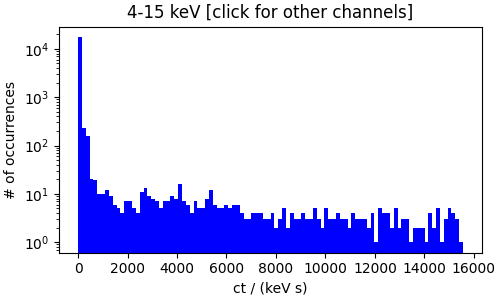
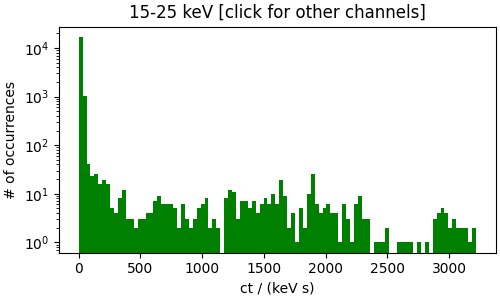
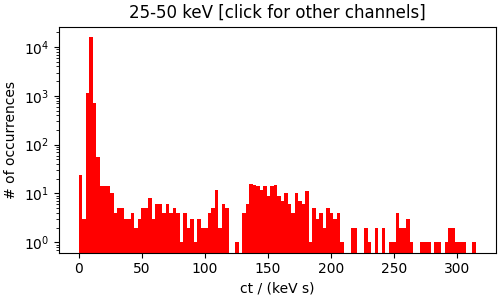
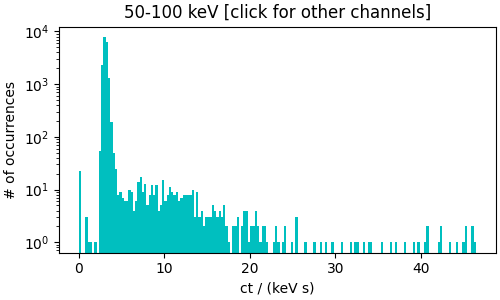
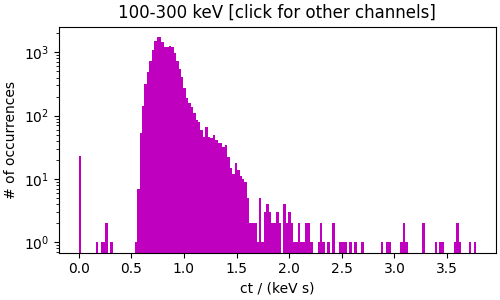
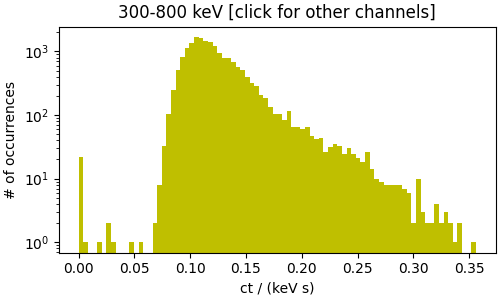
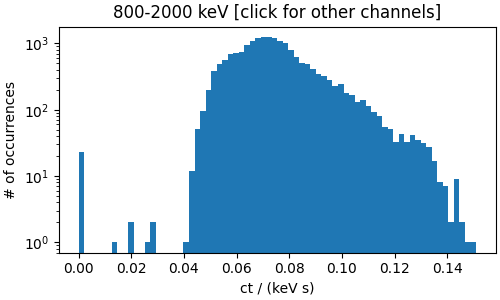
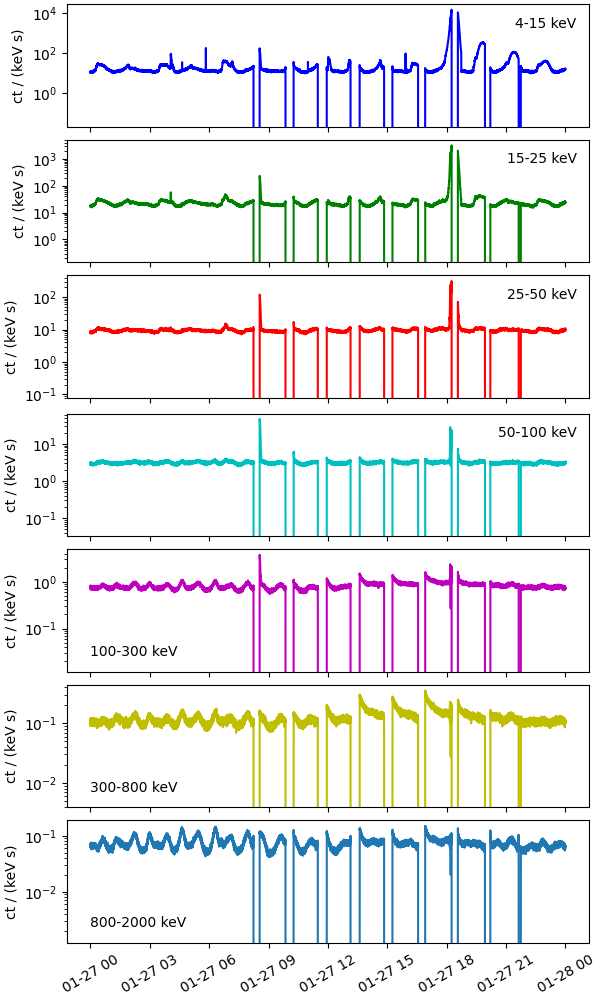
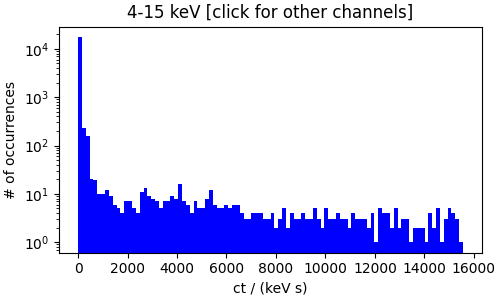

In [31]:
TimeSeries(result[0])

In [32]:
class fermi_time_handler:
    def __init__(self, MJDREFI, MJDREFF):
        self.MJDREFI = MJDREFI
        self.MJDREFF = MJDREFF

    def __str__(self):
        return f"MJDREFI: {self.MJDREFI}\nMJDREFF: {self.MJDREFF}"

    def to_datetime(self, MJD_in):
        # Step 1: Calculate reference MJD
        MJDREF = self.MJDREFI + self.MJDREFF  # Full MJD reference

        # Step 2: Convert MJD_in from seconds to days
        MJD_in_days = MJD_in / (86400)  # 86400 seconds in a day

        # Step 3: Calculate the MJD corresponding to MJD_in
        MJD = MJDREF + MJD_in_days

        # Step 4: Convert MJD to datetime
        return Time(MJD, format='mjd').datetime

# Open the RHESSI FITS file using astropy.io.fits
with astropy.io.fits.open(result[0]) as hdulist:
    fermi_time = fermi_time_handler(hdulist['GTI'].header['MJDREFI'], hdulist['GTI'].header['MJDREFF'])
    valid_times = pd.DataFrame(hdulist['GTI'].data)

valid_times[["START", "STOP"]] = valid_times[["START", "STOP"]].apply(fermi_time.to_datetime)
valid_times = valid_times[(valid_times['START'] < flare_end.iso) & (valid_times['STOP'] > flare_start.iso)]
valid_times


,START,STOP
6,2012-01-27 16:55:56.408446,2012-01-27 18:16:18.420956
7,2012-01-27 18:20:39.559588,2012-01-27 18:20:44.690568
8,2012-01-27 18:35:05.423682,2012-01-27 19:57:24.855156


c:\Users\James\Documents\code\solar_flare_finder\.venv\Lib\site-packages\sunpy\timeseries\sources\fermi_gbm.py:227: RuntimeWarning: invalid value encountered in divide
  summary_counts.append(summed_counts/energy_width/count_data["exposure"])


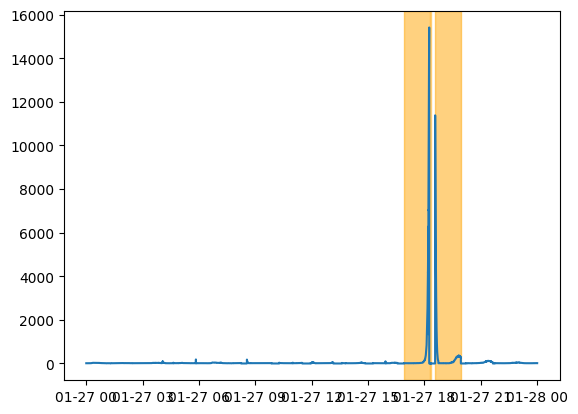

In [33]:
df = TimeSeries(result[0]).to_dataframe()

plt.plot(df.index, df['4-15 keV'])

# Shade the time ranges
for _, row in valid_times.iterrows():
    plt.axvspan(row['START'], row['STOP'], color='orange', alpha=0.5)

plt.show()

[[55953.73402778 55953.76132432]
 [55953.76434675 55953.76440614]
 [55953.77436833 55953.78888889]]


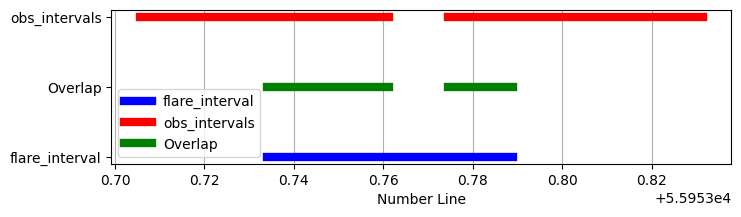

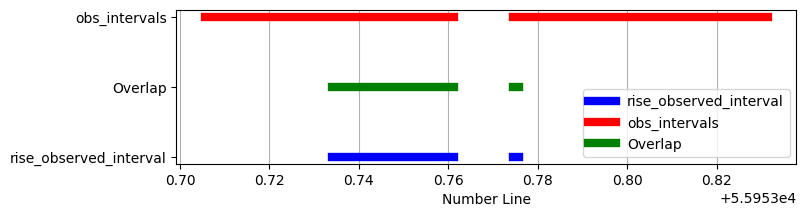

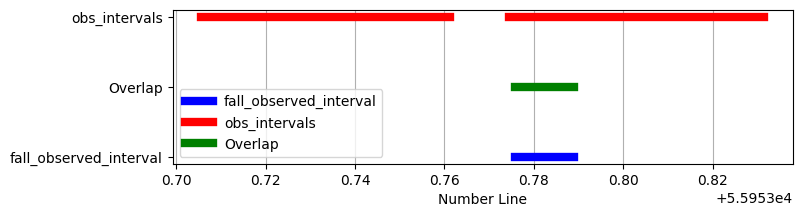

In [34]:
flare_interval = [[flare_start.mjd, flare_end.mjd]]
rise_interval = [[flare_start.mjd, flare_peak.mjd]]
fall_interval = [[flare_peak.mjd, flare_end.mjd]]

valid_times[['START_JD', 'STOP_JD']] = valid_times[['START', 'STOP']].apply(lambda x: Time(x).mjd)
obs_intervals = list(valid_times[['START_JD', 'STOP_JD']].itertuples(index=False, name=None))

flare_observed_interval = at.interval_intersection(flare_interval, obs_intervals)
rise_observed_interval = at.interval_intersection(rise_interval, obs_intervals)
fall_observed_interval = at.interval_intersection(fall_interval, obs_intervals)

print(flare_observed_interval)

at.visualise_intersections(flare_interval, obs_intervals)
at.visualise_intersections(rise_observed_interval, obs_intervals)
at.visualise_intersections(fall_observed_interval, obs_intervals)



In [36]:
flare_duration = flare_end.mjd - flare_start.mjd
flare_rise_duration = flare_peak.mjd - flare_start.mjd
flare_fall_duration = flare_end.mjd - flare_peak.mjd

print(f"Flare duration: {round(flare_duration * 1440, 2)} min")
print(f"Flare rise duration: {round(flare_rise_duration * 1440, 2)} min")
print(f"Flare fall duration: {round(flare_fall_duration * 1440, 2)} min")

observed_duration = sum([i[1] - i[0] for i in flare_observed_interval])
observed_rise_duration = sum([i[1] - i[0] for i in rise_observed_interval])
observed_fall_duration = sum([i[1] - i[0] for i in fall_observed_interval])

print()
print(f"Observed duration: {round(observed_duration * 1440, 1)} min")
print(f"Observed rise duration: {round(observed_rise_duration * 1440, 1)} min")
print(f"Observed fall duration: {round(observed_fall_duration * 1440, 1)} min")

fermi_observed = observed_duration > 0
fermi_frac_obs = observed_duration / flare_duration
fermi_frac_obs_rise = observed_rise_duration / flare_rise_duration
fermi_frac_obs_fall = observed_fall_duration / flare_fall_duration

out = {
    "fermi_observed": bool(fermi_observed),
    "fermi_frac_obs": float(fermi_frac_obs),
    "fermi_frac_obs_rise": float(fermi_frac_obs_rise),
    "fermi_frac_obs_fall": float(fermi_frac_obs_fall)
}

out

Flare duration: 79.0 min
Flare rise duration: 60.0 min
Flare fall duration: 19.0 min

Observed duration: 60.3 min
Observed rise duration: 41.3 min
Observed fall duration: 19.0 min


{'fermi_observed': True,
 'fermi_frac_obs': 0.7633181971272481,
 'fermi_frac_obs_rise': 0.6883689595088578,
 'fermi_frac_obs_fall': 1.0}

In [26]:
(55303.23779162 - 55303.23697902) * 1440  

1.1701439938042313